In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.signal
%matplotlib inline

import nest

# TODO:
# +) Impl different time delay for different networks
# 2) Choose 3 different time delays, resting state and chaotic regime, (strong, weak and no input)
# 3) Run
# 4) Analyse cross-correlation of signals, see if it picks up 
# 5) Analyse TE
# 6) Write presentation

## Step 1: Simulate mult-layer Brunel Network

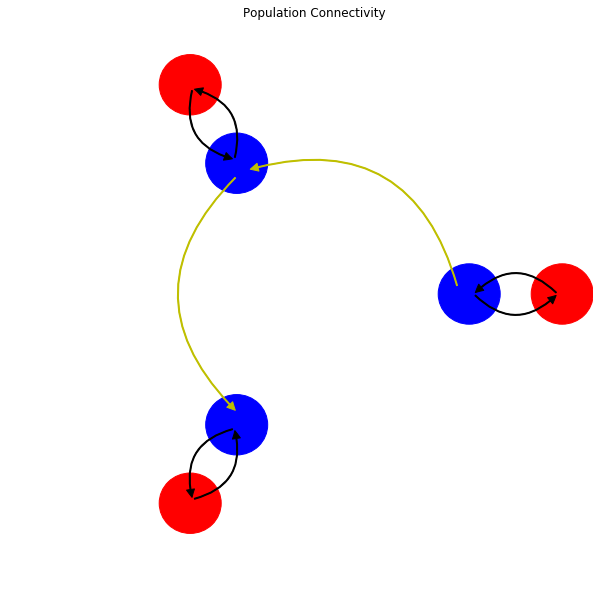

In [2]:
# SIMULATION PARAMETERS
dt = 0.1         # simulation time step size
tstop = 6000.    # simulation duration

##############################
# POPULATION PROPERTIES
##############################
VERSION = 1
N_REGION = 3
N_POPULAITONS = 2 * N_REGION
NETWORK_SIZE_FACTOR = 1000
N_E = int(0.8 * NETWORK_SIZE_FACTOR)
N_I = int(0.2 * NETWORK_SIZE_FACTOR)
N_NEURON_PP = [N_E, N_I] * N_REGION   # number of neurons in each population

##############################
# Connectivity Properties
##############################

# Connection probabilities
PCONN_EE = 0.2  # EXC-EXC connectivity probability
PCONN_EI = 0.2  # EXC-INH connectivity probability
PCONN_IE = 0.2  # INH-EXC connectivity probability
PCONN_II = 0.2  # INH-INH connectivity probability
PCONN_LL = 0.05  # EXC-EXC layer to layer connectivity probability

# Synapse properties
WEIGHT_SCALE = 2.0   # [2.0, 4.0]
W_EXC_MAX = WEIGHT_SCALE
W_INH_MAX = -4 * WEIGHT_SCALE
SYN_DELAY_IL = 1.5
SYN_DELAY_LL = 200.0   # [50.0, 200.0, 800.0]

##############################
# Stimulus properties
##############################
STIM_MAG = 10.0    # [0.0, 10.0, 50.0]
STIM_FREQ = 1.0    # [20.0, 1.0]

NOISE_RATE = 6000.
W_NOISE_MAX = 10.0
W_NOISE_MAX = [W_NOISE_MAX] * N_POPULAITONS # max input weight of noise


##############################
# Connectivity
##############################

# Inter-layer connectivity graph
LL_CONN_REGIONS     = [(0, 1), (1, 2)]
LL_CONN_POPULATIONS = [(2*i, 2*j) for i,j in LL_CONN_REGIONS]
CONN_GRAPH_POPULATIONS = []

# Construct connectivity within each layer
for i in range(N_REGION):
    CONN_GRAPH_POPULATIONS += [
        (2*i,   2*i,   {'WMAX' : W_EXC_MAX, 'PCONN' : PCONN_EE, 'DELAY' : SYN_DELAY_IL}),
        (2*i,   2*i+1, {'WMAX' : W_EXC_MAX, 'PCONN' : PCONN_EI, 'DELAY' : SYN_DELAY_IL}),
        (2*i+1, 2*i,   {'WMAX' : W_INH_MAX, 'PCONN' : PCONN_IE, 'DELAY' : SYN_DELAY_IL}),
        (2*i+1, 2*i+1, {'WMAX' : W_INH_MAX, 'PCONN' : PCONN_II, 'DELAY' : SYN_DELAY_IL})
    ]
    
# Construct inter-layer connectivity
for i,j in LL_CONN_POPULATIONS:    
    CONN_GRAPH_POPULATIONS += [(i, j,   {'WMAX' : W_EXC_MAX, 'PCONN' : PCONN_LL, 'DELAY' : SYN_DELAY_LL})]
    
##############################
# Plot connectivity graph
##############################
def polar(r, phi):
    return r * np.array([np.cos(phi), np.sin(phi)])

def makeArrow(pos, col, ax):
    kw = dict(arrowstyle="Simple,tail_width=1,head_width=8,head_length=8", color=col)
    posPrim = [0.95*pos[0] + 0.05*pos[1], 0.05*pos[0] + 0.95*pos[1]]
    arrow123 = patches.FancyArrowPatch(posPrim[0], posPrim[1], connectionstyle="arc3,rad=.5", **kw)
    ax.add_patch(arrow123)
    

graph_r = 10
graph_rc = [50, 80]
graph_color_type = ['blue', 'red']

ctype = [i % 2 for i in range(N_POPULAITONS)]  # Cell types
graph_phi = [2 * np.pi * (i // 2) / N_REGION for i in range(N_POPULAITONS)]
graph_coord = [polar(graph_rc[ctype[i]], graph_phi[i]) for i in range(N_POPULAITONS)]
graph_color = [graph_color_type[ctype[i]] for i in range(N_POPULAITONS)]

# Nodes
fig, ax = plt.subplots(figsize = (10, 10))
for i in range(N_POPULAITONS):
    circ = plt.Circle(graph_coord[i], graph_r, color=graph_color[i])
    ax.add_patch(circ)
    
# Connections

for i, j, param in CONN_GRAPH_POPULATIONS:
    color = 'k' if np.abs(i - j) == 1 else 'y'
    makeArrow([graph_coord[i], graph_coord[j]], color, ax)

plt.axis('off')
ax.set_title('Population Connectivity')
ax.set_xlim(-(graph_rc[1]+graph_r), (graph_rc[1]+graph_r))
ax.set_ylim(-(graph_rc[1]+graph_r), (graph_rc[1]+graph_r))
plt.show()

In [3]:
%%time

# reset kernel and set dt
nest.ResetKernel()
nest.SetKernelStatus({'resolution': dt})

# create nodes
neuron_nodes           = [nest.Create('iaf_psc_alpha', n) for n in N_NEURON_PP]
neuron_spike_detectors = [nest.Create('spike_detector') for i in range(N_POPULAITONS)]
noise_generator        = nest.Create('poisson_generator', params={'rate' : NOISE_RATE})
ac_generator           = nest.Create('ac_generator', params={'amplitude' : STIM_MAG, 'frequency' : STIM_FREQ})


# Connect input to 0th node
nest.Connect(ac_generator, neuron_nodes[0], conn_spec='all_to_all')

# create connections
for i in range(N_POPULAITONS):
    # Connect detectors to populations
    nest.Connect(neuron_nodes[i], neuron_spike_detectors[i], conn_spec='all_to_all')
    
    # Connect noise to populations
    nest.Connect(noise_generator, neuron_nodes[i], 
                 conn_spec='all_to_all', 
                 syn_spec={'weight': W_NOISE_MAX[i], 'delay': dt})

for i, j, param in CONN_GRAPH_POPULATIONS:
    # Connect populations to each other
    nest.Connect(neuron_nodes[i], neuron_nodes[j],
                 conn_spec={'rule': 'pairwise_bernoulli', 'p': param['PCONN']}, 
                 syn_spec={'model':'static_synapse', 'weight': param['WMAX'], 'delay' : param['DELAY']})

# simulate
nest.Simulate(tstop)

CPU times: user 21.6 s, sys: 182 ms, total: 21.8 s
Wall time: 21.7 s


In [4]:
# # plot spiking activity
# import nest.raster_plot
# for detector in neuron_spike_detectors:
#     nest.raster_plot.from_device(detector)

## Step 2. Analyse the network and write it to file

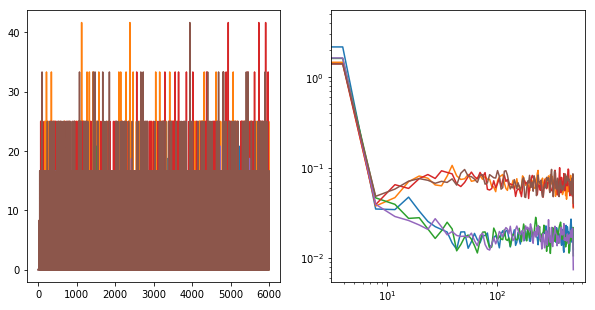

In [5]:
outputName = 'data_V' + str(VERSION)
outputName += '_N' + str(N_REGION)
outputName += '_W' + str(WEIGHT_SCALE)
outputName += '_W' + str(WEIGHT_SCALE)
outputName += '_DT' + str(SYN_DELAY_LL)
outputName += '_SM' + str(STIM_MAG)
outputName += '_SF' + str(STIM_FREQ)

logFile = open(outputName+"_log.txt", "w")

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
for i in range(N_POPULAITONS):
    tspk = nest.GetStatus(neuron_spike_detectors[i])[0]['events']['times']
    nspk = nest.GetStatus(neuron_spike_detectors[i])[0]['events']['senders']
    avgrate = len(tspk) / (tstop / 1000) / N_NEURON_PP[i]
    logFile.write("Ensemble" + str(i) + " avgrate =" + str(int(avgrate*100)/100))
        
    nBins = 10000
    bins = np.linspace(0, tstop, nBins)
    hist, _ = np.histogram(tspk, bins=bins)
    histNorm = hist * nBins / (tstop / 1000) / N_NEURON_PP[i]
    pxx,f = plt.mlab.psd(histNorm, Fs=1000)  # Power spectral density
    
    ax[0].plot(bins[:-1], histNorm)
    ax[1].loglog(f, pxx)
    
plt.savefig(outputName + '_PSD.png')


In [6]:
import csv

with open(outputName +'_spikes.txt', "w") as f:
    writer = csv.writer(f)
    writer.writerow(['populationIdx', 'spiketimes', 'neuronIdx'])
    
    for i in range(N_POPULAITONS):
        # Only write excitatory population data
        if (i % 2 == 0):
            tspk = nest.GetStatus(neuron_spike_detectors[i])[0]['events']['times']
            nspk = nest.GetStatus(neuron_spike_detectors[i])[0]['events']['senders']

            for t, n in zip(tspk, nspk):
                writer.writerow([i//2, t, n])
        

with open(outputName + '_populations.txt', "w") as f:
    writer = csv.writer(f)
    for i in range(N_POPULAITONS):
        ids = nest.GetStatus(neuron_nodes[i], 'global_id')
        writer.writerow([i, ids[0], ids[-1]])

## Step 3. Compute microscopic metrics and write them to file

extracted connectivity map
CPU times: user 1.42 s, sys: 353 ms, total: 1.78 s
Wall time: 1.38 s


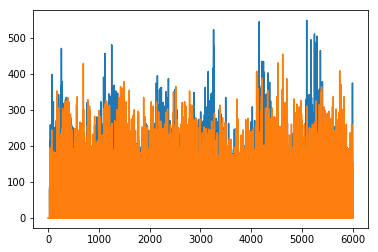

In [7]:
%%time
#######################################
# 1. Extract inter-layer connectivity
#######################################

# Learn to map from neuron index to population index
# FIXME: Surely, there is a built-in function
NEURON_IDXS = [0]
for i in range(N_POPULAITONS):
    NEURON_IDXS.append(NEURON_IDXS[i] + N_NEURON_PP[i])
NEURON_IDXS = NEURON_IDXS[1:]
N_NEURON_TOT = NEURON_IDXS[-1]
    
def getPopIdx(neuronIdx):
    i = 0
    while NEURON_IDXS[i] <= neuronIdx:
        i += 1
    return i

# Find out how many times each neuron maps to another region
connMap = np.zeros((N_NEURON_TOT, len(LL_CONN_POPULATIONS)))

for arr in nest.GetConnections():
    src = arr[0]-1
    trg = arr[1]-1
    
    if (src < N_NEURON_TOT) and (trg < N_NEURON_TOT):
        linkIdx = (getPopIdx(src), getPopIdx(trg))
        
        if linkIdx in LL_CONN_POPULATIONS:
            connMap[src][LL_CONN_POPULATIONS.index(linkIdx)] += W_EXC_MAX

print("extracted connectivity map")
######################################################
# 2. Convert spikes into cross-layer energy transfer
######################################################

MIN_TIME = 0
MAX_TIME = tstop
times_discr = np.arange(MIN_TIME, MAX_TIME + dt, dt)
micro_energy = np.zeros((len(LL_CONN_POPULATIONS), len(times_discr)))

for iPop in range(N_POPULAITONS):
    # Only consider excitatory population data
    if (iPop % 2 == 0):
        tspk = nest.GetStatus(neuron_spike_detectors[iPop])[0]['events']['times']
        nspk = nest.GetStatus(neuron_spike_detectors[iPop])[0]['events']['senders']
        
        for t,n in zip(tspk, nspk):
            timeIdx = int((t - MIN_TIME)/dt)
            for iLink in range(len(LL_CONN_POPULATIONS)):
                micro_energy[iLink][timeIdx] += connMap[n-1][iLink]
            

for i in range(len(micro_energy)):
    nSourceNeuron = N_NEURON_PP[LL_CONN_POPULATIONS[i][0]]
    totEnergyTransfer = np.sum(micro_energy[i]) / (tstop / 1000)
    trueFunConn = totEnergyTransfer / nSourceNeuron
    outStr = "connection" + str(LL_CONN_REGIONS[i])
    outStr += " nSourceNeuron=" + str(nSourceNeuron)
    outStr += " trueFunConn=" + str(int(trueFunConn * 100)/100)
    logFile.write(outStr)
    
    
plt.figure()
for i in range(len(micro_energy)):
    plt.plot(times_discr, micro_energy[i])
    
plt.savefig(outputName + '_EnergyT.png')

In [8]:
# Close everything
logFile.close()